# Are Taylor Swift's songs too boring?

* This project was inspired by a conversation I had with someone that criticised Taylor Swift's songs had the same themes and use the same literary motifs.

* In this project, I aim to collect lyrics of songs performed by Taylor Swift to look into this.

In [22]:
import os
import json
import tokenizer
from tqdm import tqdm
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import nltk
nltk.download('stopwords')

load_dotenv()
SUBJECT = 'Taylor Swift'

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/solanyn/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Collecting our data

In [6]:
import lyricsgenius

genius = lyricsgenius.Genius(os.environ['CLIENT_ACCESS_TOKEN'])
genius.remove_section_headers = True
genius.excluded_terms = ["(Remix)", "(Live)"]

In [8]:
artist = genius.search_artist(SUBJECT)
lyrics = artist.save_lyrics()

Searching for songs by Taylor Swift...

Song 1: "​cardigan"
Song 2: "​exile"
Song 3: "Lover"
Song 4: "​the 1"
Song 5: "Look What You Made Me Do"
Song 6: "​betty"
Song 7: "End Game"
Song 8: "​august"
Song 9: "ME!"
Song 10: "You Need To Calm Down"
Song 11: "...Ready for It?"
Song 12: "Blank Space"
Song 13: "​my tears ricochet"
Song 14: "​champagne problems"
Song 15: "​willow"
Song 16: "​invisible string"
Song 17: "​the last great american dynasty"
Song 18: "Delicate"
Song 19: "Call It What You Want"
Song 20: "Cruel Summer"
"Bad Blood (Remix)" is not valid. Skipping.
"I Don’t Wanna Live Forever" is not valid. Skipping.
Song 21: "Style"
Song 22: "​seven"
Song 23: "​illicit affairs"
Song 24: "​this is me trying"
Song 25: "Gorgeous"
Song 26: "​evermore"
Song 27: "​peace"
Song 28: "​mad woman"
Song 29: "Love Story"
Song 30: "​mirrorball"
Song 31: "The Man"
Song 32: "Don’t Blame Me"
Song 33: "I Did Something Bad"
Song 34: "Dress"
Song 35: "​happiness"
Song 36: "​hoax"
Song 37: "​no body, no cr

In [9]:
print(artist.songs)

[Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, artist, ...), Song(id, a

In [10]:
artist.save_lyrics('tswizzle.json')

Wrote tswizzle.json.


## Preprocessing text data

In [2]:
with open('Lyrics_TaylorSwift.json', 'r') as f:
    data = json.loads(f.read())

In [3]:
songs_dict = {
    'title': [],
    'artist': [],
    'release_date': [],
    'album': [],
    'lyrics': []
}

for i in range(len(data['songs'])):
    songs_dict['title'].append(data['songs'][i]['title'])
    songs_dict['artist'].append(data['songs'][i]['artist'])
    # TODO: Fix if album is N/A
    if data['songs'][i]['album'] is not None:
        songs_dict['album'].append(data['songs'][i]['album']['name'])
    else:
        songs_dict['album'].append(None)
    songs_dict['release_date'].append(data['songs'][i]['release_date'])
    songs_dict['lyrics'].append(data['songs'][i]['lyrics'])

songs_df = pd.DataFrame(songs_dict)

In [4]:
%%time
# Loads GloVe embeddings
glove_embeddings = {}
with open("glove.6B.50d.txt") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], "float32")
        glove_embeddings[word] = coefs
f.close()

print("Found %s word vectors." % len(glove_embeddings))

Found 400000 word vectors.
CPU times: user 6.11 s, sys: 276 ms, total: 6.39 s
Wall time: 6.44 s


In [5]:
# Checks intersect of our vocabulary and GloVe embeddings
# Outputs list of out of vocabulary of words

import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [41]:
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


def handle_contractions(x):
    tb_tokenizer = TreebankWordTokenizer()
    x = tb_tokenizer.tokenize(x)
    x = ' '.join(x)
    return x

def preprocess(text, keep_hashtags=True):
    tokenizer = TweetTokenizer(preserve_case=True, reduce_len=True, strip_handles=True)
    tokens = tokenizer.tokenize(text)
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    l = []

    for token in tokens:
        if token[0] == "#" and not keep_hashtags:
            continue
        if token[:4] == "http":
            continue
        if token.isnumeric() or not token[0].isalpha():
            continue
        if token[0] == "@":
            continue
        if token in stop_words:
            continue

        if "'" in token:
            l.append(ps.stem(token.lower()))
        else:
            l.append(ps.stem(token.lower()))
    return " ".join(l)

In [42]:
vocab = build_vocab(list(songs_df['lyrics'].apply(lambda x: preprocess(x).split())))
oov = check_coverage(vocab, glove_embeddings)
oov[:10]

100%|██████████| 5035/5035 [00:00<00:00, 937675.19it/s]

Found embeddings for 71.00% of vocab
Found embeddings for  85.38% of all text


[("i'm", 896),
 ("can't", 295),
 ("i'll", 283),
 ("that'", 279),
 ("it'", 269),
 ("i'v", 214),
 ('everi', 206),
 ("i'd", 205),
 ('everyth', 204),
 ('littl', 189)]

In [43]:
# TODO: Build some wordcloud showing commonly used words in Taylor Swift songs
import wordcloud

words = []
for word, count in vocab.items():
    words.extend([word] * count)
words = ' '.join(words)
    
wcloud = wordcloud.WordCloud().generate(words)

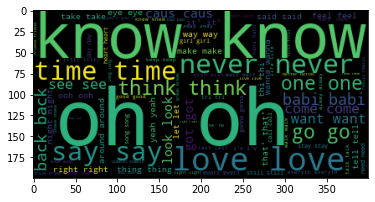

In [44]:
import matplotlib.pyplot as plt

plt.imshow(wcloud)
plt.show()